In [300]:
import pandas as pd
from sklearn.cluster import KMeans
from transformers import BertTokenizer, BertModel
import torch
torch.cuda.is_available()

True

In [301]:
features_file = r'C:\ML\28_final_task\Online Retail.xlsx'
df = pd.read_excel(features_file)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [302]:
df['Description'].fillna('Прочие', inplace=True)
df['CustomerID'].fillna(-999999, inplace=True)
df['InvoiceNo'].fillna('без номера', inplace=True)
df['Return'] = df['InvoiceNo'].astype(str).str.startswith('C').astype(int)
df['Description'] = df['Description'].str.strip()

df_without_other = df[df['Description'] != 'Прочие']
unique_descriptions = df_without_other[['Description']].drop_duplicates()
unique_descriptions = unique_descriptions.reset_index(drop=True)
print("DataFrame с уникальными товарами:")
unique_descriptions


C:\Users\avsip\AppData\Local\Temp\ipykernel_14952\1594174929.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Description'].fillna('Прочие', inplace=True)
C:\Users\avsip\AppData\Local\Temp\ipykernel_14952\1594174929.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

DataFrame с уникальными товарами:


,Description
0,WHITE HANGING HEART T-LIGHT HOLDER
1,WHITE METAL LANTERN
2,CREAM CUPID HEARTS COAT HANGER
3,KNITTED UNION FLAG HOT WATER BOTTLE
4,RED WOOLLY HOTTIE WHITE HEART.
...,...
4206,????damages????
4207,mixed up
4208,lost
4209,CREAM HANGING HEART T-LIGHT HOLDER


In [303]:
descriptions = unique_descriptions['Description'].tolist()
unique_descriptions['Description'] = unique_descriptions['Description'].astype(str)


Batches: 100%|██████████| 132/132 [00:00<00:00, 143.20it/s]


Number of clusters: 11


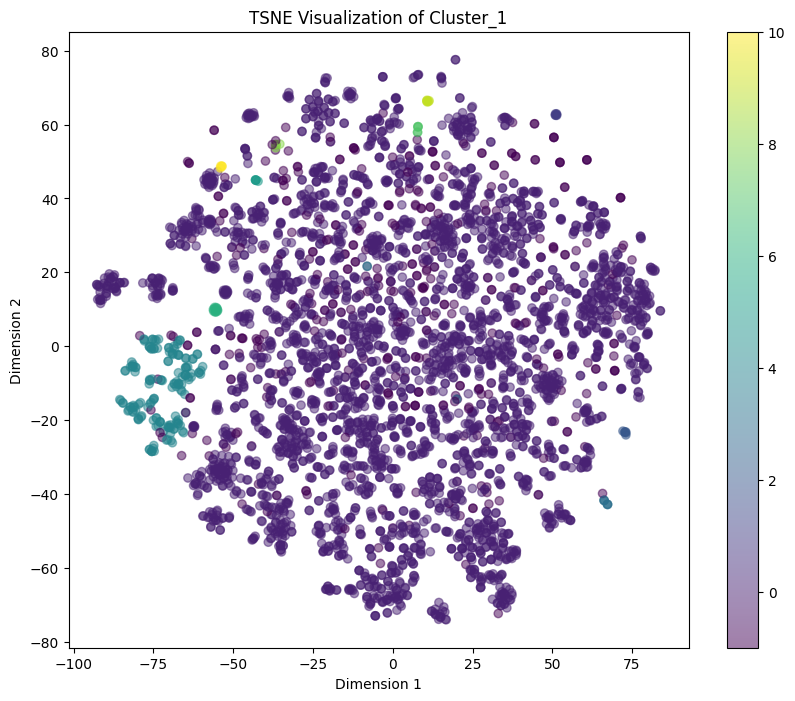

In [251]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer('paraphrase-MiniLM-L6-v2', device=device)
embeddings = model.encode(descriptions, show_progress_bar=True, device=device)
scaler = StandardScaler()
normalized_embeddings = scaler.fit_transform(embeddings)
tsne = TSNE(n_components=2, random_state=0)
reduced_embeddings = tsne.fit_transform(normalized_embeddings)
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='cosine')
clusters_1 = dbscan.fit_predict(normalized_embeddings)
num_clusters = len(set(clusters_1)) - (1 if -1 in clusters_1 else 0)
print("Number of clusters:", num_clusters)
unique_descriptions['Cluster_1'] = clusters_1
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters_1, cmap='viridis', alpha=0.5)
plt.colorbar(scatter)
plt.title('TSNE Visualization of Cluster_1')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [252]:
for cluster_num in set(clusters_1):
    if cluster_num != -1:
        cluster_df = unique_descriptions[unique_descriptions['Cluster_1'] == cluster_num]['Description'].value_counts().head(20)
        print(f"Cluster {cluster_num}:")
        print(cluster_df.index.tolist())
        print("\n")

Cluster 0:
['WHITE HANGING HEART T-LIGHT HOLDER', 'PURPLE VINTAGE EARRINGS', 'SMALL SKULL WINDMILL', 'HOT WATER BOTTLE BABUSHKA LARGE', 'EASTER CRAFT 4 CHICKS', 'BLACK CRYSTAL DROP EARRINGS', 'CRACKED GLAZE EARRINGS BROWN', 'MOP PENDANT SHELL NECKLACE', 'DIAMANTE NECKLACE BLACK', 'Dotcomgiftshop Gift Voucher £40.00', 'WHITE HEART CONFETTI IN TUBE', 'GLASS BEAD HOOP EARRINGS AMETHYST', 'OPIUM SCENTED VOTIVE CANDLE', 'LOVE HEART TRINKET POT', 'ACRYLIC HANGING JEWEL,BLUE', 'GLOW IN DARK DOLPHINS', 'CHEST NATURAL WOOD 20 DRAWERS', 'PINK PAPER PARASOL', 'WHITE BIRD GARDEN DESIGN MUG', 'LARGE ROUND CUTGLASS CANDLESTICK']


Cluster 1:
['POLYESTER FILLER PAD 45x45cm', 'POLYESTER FILLER PAD 45x30cm', 'POLYESTER FILLER PAD 40x40cm', 'POLYESTER FILLER PAD 65CMx65CM', 'POLYESTER FILLER PAD 30CMx30CM', 'POLYESTER FILLER PAD 60x40cm']


Cluster 2:
['HERB MARKER MINT', 'HERB MARKER ROSEMARY', 'HERB MARKER BASIL', 'HERB MARKER CHIVES', 'HERB MARKER PARSLEY', 'HERB MARKER THYME']


Cluster 3:
['BLUE DR

In [253]:
num_clusters = len(set(clusters_1)) - (1 if -1 in clusters_1 else 0)
print(f"Number of clusters: {num_clusters}")

Number of clusters: 11


Batches: 100%|██████████| 132/132 [00:00<00:00, 144.80it/s]


Best parameters: eps=0.2, min_samples=1
Best Silhouette Score: 0.21074555814266205


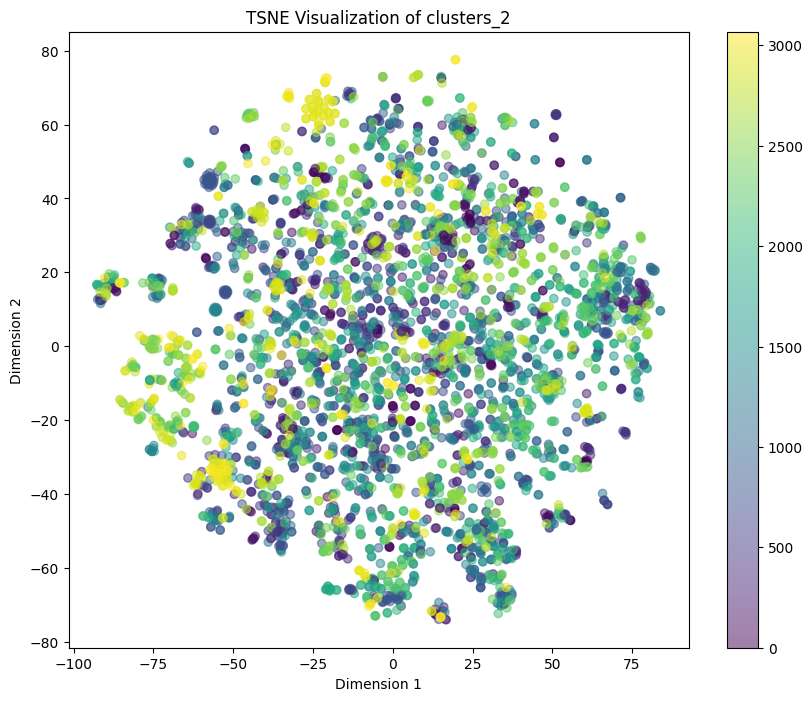

In [254]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer('paraphrase-MiniLM-L6-v2', device=device)
embeddings = model.encode(descriptions, show_progress_bar=True, device=device)

scaler = StandardScaler()
normalized_embeddings = scaler.fit_transform(embeddings)

tsne = TSNE(n_components=2, random_state=0)
reduced_embeddings = tsne.fit_transform(normalized_embeddings)

eps_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] 
min_samples_values = [1, 2, 3, 4, 5, 6, 7, 8]

best_score = -1
best_params = (None, None)
best_clusters = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        clusters = dbscan.fit_predict(normalized_embeddings)
        if len(set(clusters)) > 1:
            silhouette_avg = silhouette_score(normalized_embeddings, clusters, metric='cosine')
            if silhouette_avg > best_score:
                best_score = silhouette_avg
                best_params = (eps, min_samples)
                best_clusters = clusters

print(f'Best parameters: eps={best_params[0]}, min_samples={best_params[1]}')
print(f'Best Silhouette Score: {best_score}')

dbscan = DBSCAN(eps=best_params[0], min_samples=best_params[1], metric='cosine')
clusters_2 = dbscan.fit_predict(normalized_embeddings)

unique_descriptions['clusters_2'] = clusters
df = df.merge(unique_descriptions[['Description', 'clusters_2']], on='Description', how='left')

plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters_2, cmap='viridis', alpha=0.5)
plt.colorbar(scatter)
plt.title('TSNE Visualization of clusters_2')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [255]:
len(unique_descriptions)

4210

In [257]:
num_clusters = len(set(clusters_2)) - (1 if -1 in clusters_2 else 0)
print(f"Number of clusters: {num_clusters}")

Number of clusters: 3069


Using model: paraphrase-MiniLM-L6-v2


Batches: 100%|██████████| 132/132 [00:00<00:00, 153.74it/s]


Testing KMeans with k=2
K=2, Silhouette Score: 0.05801863223314285
Testing KMeans with k=3
K=3, Silhouette Score: 0.058912940323352814
Testing KMeans with k=4
K=4, Silhouette Score: 0.06015502288937569
Testing KMeans with k=5
K=5, Silhouette Score: 0.06339877098798752
Testing KMeans with k=6
K=6, Silhouette Score: 0.06645110994577408
Using model: all-MiniLM-L6-v2


Batches: 100%|██████████| 132/132 [00:00<00:00, 138.95it/s]


Testing KMeans with k=2
K=2, Silhouette Score: 0.05187907814979553
Testing KMeans with k=3
K=3, Silhouette Score: 0.04770687595009804
Testing KMeans with k=4
K=4, Silhouette Score: 0.049637384712696075
Testing KMeans with k=5
K=5, Silhouette Score: 0.051845695823431015
Testing KMeans with k=6
K=6, Silhouette Score: 0.05962826684117317
Using model: bert-base-uncased


No sentence-transformers model found with name bert-base-uncased. Creating a new one with mean pooling.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to 

Testing KMeans with k=2
K=2, Silhouette Score: 0.08130145072937012
Testing KMeans with k=3
K=3, Silhouette Score: 0.07295209169387817
Testing KMeans with k=4
K=4, Silhouette Score: 0.06775904446840286
Testing KMeans with k=5
K=5, Silhouette Score: 0.07064010202884674
Testing KMeans with k=6
K=6, Silhouette Score: 0.07007578760385513
Best model: bert-base-uncased
Best number of clusters (K): 2
Best Silhouette Score: 0.08130145072937012


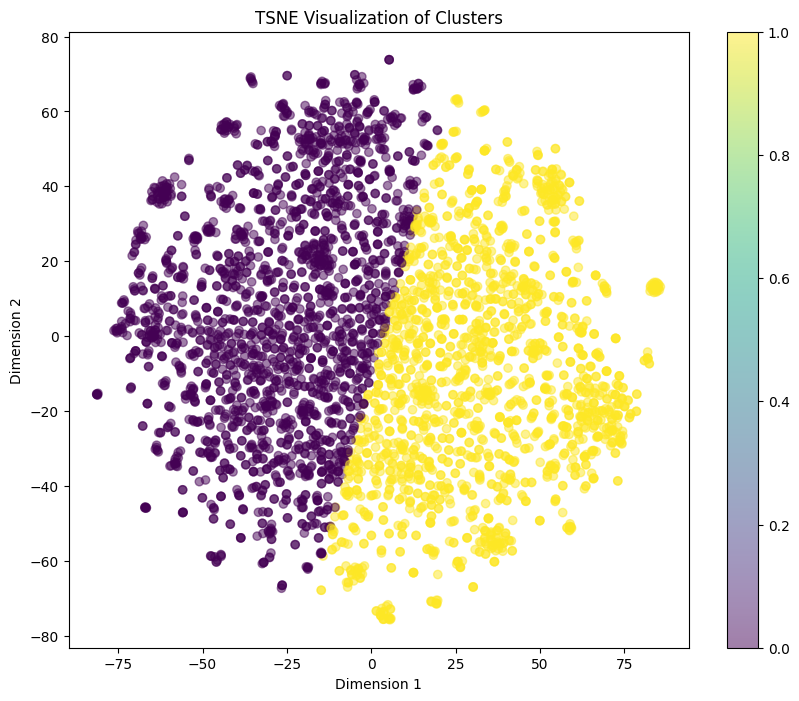

In [258]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Определение моделей для тестирования
models = [
    'paraphrase-MiniLM-L6-v2',
    'all-MiniLM-L6-v2',
    'bert-base-uncased'
]

k_values = [2, 3, 4, 5, 6]

best_score = -1
best_model_name = None
best_k = None
best_clusters = None
best_embeddings = None

for model_name in models:
    print(f"Using model: {model_name}")

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = SentenceTransformer(model_name, device=device)
    embeddings = model.encode(descriptions, show_progress_bar=True, device=device)
    scaler = StandardScaler()
    normalized_embeddings = scaler.fit_transform(embeddings)
    
    tsne = TSNE(n_components=2, random_state=0)
    reduced_embeddings = tsne.fit_transform(normalized_embeddings)
    
    for k in k_values:
        print(f"Testing KMeans with k={k}")

        kmeans = KMeans(n_clusters=k, random_state=0)
        clusters = kmeans.fit_predict(normalized_embeddings)

        silhouette_avg = silhouette_score(normalized_embeddings, clusters, metric='cosine')
        print(f'K={k}, Silhouette Score: {silhouette_avg}')
        
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_model_name = model_name
            best_k = k
            best_clusters = clusters
            best_embeddings = reduced_embeddings

print(f'Best model: {best_model_name}')
print(f'Best number of clusters (K): {best_k}')
print(f'Best Silhouette Score: {best_score}')

kmeans = KMeans(n_clusters=best_k, random_state=0)
clusters_3 = kmeans.fit_predict(best_embeddings)

unique_descriptions['clusters_3'] = clusters

plt.figure(figsize=(10, 8))
scatter = plt.scatter(best_embeddings[:, 0], best_embeddings[:, 1], c=clusters_3, cmap='viridis', alpha=0.5)
plt.colorbar(scatter)
plt.title('TSNE Visualization of Clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [259]:
print(f'Best model: {best_model_name}')
print(f'Best number of clusters (K): {best_k}')
print(f'Best Silhouette Score: {best_score}')

Best model: bert-base-uncased
Best number of clusters (K): 2
Best Silhouette Score: 0.08130145072937012


In [260]:
for cluster_num in set(clusters_3):
    if cluster_num != -1:
        cluster_df = unique_descriptions[unique_descriptions['clusters_3'] == cluster_num]['Description'].value_counts()
        
        top_items = cluster_df.head(10)
        print(f"Cluster {cluster_num}:")
        print(top_items.index.tolist())
        print("\n")

Cluster 0:
['SET 7 BABUSHKA NESTING BOXES', 'RECYCLED ACAPULCO MAT GREEN', 'incorrectly made-thrown away.', 'SET OF 4 PANTRY JELLY MOULDS', 'TRAVEL CARD WALLET TRANSPORT', 'TRAVEL CARD WALLET RETROSPOT', 'TRAVEL CARD WALLET KEEP CALM', 'TRAVEL CARD WALLET RETRO PETALS', 'TRAVEL CARD WALLET SUKI', 'TRAVEL CARD WALLET VINTAGE TICKET']


Cluster 1:
['WHITE METAL LANTERN', 'DOLLCRAFT GIRL AMELIE KIT', 'BOYS PARTY BAG', 'GIRLS PARTY BAG', 'RETRO PILL BOX , REVOLUTIONARY', 'FOLDING SHOE TIDY', 'MADRAS NOTEBOOK MEDIUM', 'PANTRY SCRUBBING BRUSH', 'TRAVEL CARD WALLET PANTRY', 'TRAVEL CARD WALLET SKULLS']




Using model: paraphrase-MiniLM-L6-v2


Batches: 100%|██████████| 132/132 [00:00<00:00, 144.10it/s]


Testing KMeans with k=2
K=2, Silhouette Score: 0.05801863223314285
K=2, Calinski-Harabasz Score: 128.3477003241944
K=2, Davies-Bouldin Score: 5.596561691059135
Testing KMeans with k=3
K=3, Silhouette Score: 0.058912940323352814
K=3, Calinski-Harabasz Score: 115.77384947775583
K=3, Davies-Bouldin Score: 5.04828669224392
Testing KMeans with k=4
K=4, Silhouette Score: 0.06015502288937569
K=4, Calinski-Harabasz Score: 103.94490636247419
K=4, Davies-Bouldin Score: 4.765374397885086
Testing KMeans with k=5
K=5, Silhouette Score: 0.06339877098798752
K=5, Calinski-Harabasz Score: 96.80408221552476
K=5, Davies-Bouldin Score: 4.761435959464384
Testing KMeans with k=6
K=6, Silhouette Score: 0.06645110994577408
K=6, Calinski-Harabasz Score: 91.84504111802983
K=6, Davies-Bouldin Score: 4.338331019827023
Using model: all-MiniLM-L6-v2


Batches: 100%|██████████| 132/132 [00:00<00:00, 140.38it/s]


Testing KMeans with k=2
K=2, Silhouette Score: 0.05187907814979553
K=2, Calinski-Harabasz Score: 113.22801777596958
K=2, Davies-Bouldin Score: 5.789846265380892
Testing KMeans with k=3
K=3, Silhouette Score: 0.04770687595009804
K=3, Calinski-Harabasz Score: 92.79937982054878
K=3, Davies-Bouldin Score: 6.001197251999295
Testing KMeans with k=4
K=4, Silhouette Score: 0.049637384712696075
K=4, Calinski-Harabasz Score: 85.044591355984
K=4, Davies-Bouldin Score: 5.4198730757778675
Testing KMeans with k=5
K=5, Silhouette Score: 0.051845695823431015
K=5, Calinski-Harabasz Score: 79.37818660068677
K=5, Davies-Bouldin Score: 5.027101428442696
Testing KMeans with k=6
K=6, Silhouette Score: 0.05962826684117317
K=6, Calinski-Harabasz Score: 77.45677398790771
K=6, Davies-Bouldin Score: 4.774141205160862
Using model: bert-base-uncased


No sentence-transformers model found with name bert-base-uncased. Creating a new one with mean pooling.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to 

Testing KMeans with k=2
K=2, Silhouette Score: 0.08130145072937012
K=2, Calinski-Harabasz Score: 190.3415147496479
K=2, Davies-Bouldin Score: 4.657429118199315
Testing KMeans with k=3
K=3, Silhouette Score: 0.07295209169387817
K=3, Calinski-Harabasz Score: 154.82296054193924
K=3, Davies-Bouldin Score: 4.592057194300371
Testing KMeans with k=4
K=4, Silhouette Score: 0.06775904446840286
K=4, Calinski-Harabasz Score: 128.47221508981613
K=4, Davies-Bouldin Score: 4.523837863431495
Testing KMeans with k=5
K=5, Silhouette Score: 0.07064010202884674
K=5, Calinski-Harabasz Score: 115.68354480198815
K=5, Davies-Bouldin Score: 4.284615433680568
Testing KMeans with k=6
K=6, Silhouette Score: 0.07007578760385513
K=6, Calinski-Harabasz Score: 102.88242197580043
K=6, Davies-Bouldin Score: 4.209589584445742
Best model: bert-base-uncased
Best number of clusters (K): 2
Best Silhouette Score: 0.08130145072937012


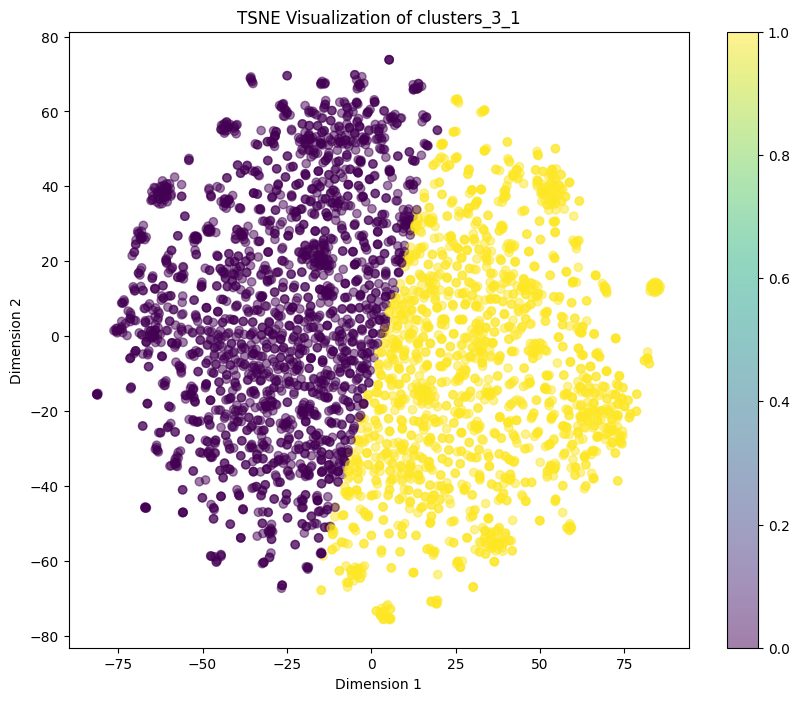

In [261]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sentence_transformers import SentenceTransformer
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

models = [
    'paraphrase-MiniLM-L6-v2',
    'all-MiniLM-L6-v2',
    'bert-base-uncased'
]

k_values = [2, 3, 4, 5, 6]

best_score = -1
best_model_name = None
best_k = None
best_clusters = None
best_embeddings = None

for model_name in models:
    print(f"Using model: {model_name}")

    # Использование SentenceTransformer для получения эмбеддингов
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = SentenceTransformer(model_name, device=device)
    embeddings = model.encode(descriptions, show_progress_bar=True, device=device)
    
    # Нормализация эмбеддингов
    scaler = StandardScaler()
    normalized_embeddings = scaler.fit_transform(embeddings)
    
    # Уменьшение размерности для визуализации
    tsne = TSNE(n_components=2, random_state=0)
    reduced_embeddings = tsne.fit_transform(normalized_embeddings)
    
    for k in k_values:
        print(f"Testing KMeans with k={k}")

        # Кластеризация с использованием KMeans
        kmeans = KMeans(n_clusters=k, random_state=0)
        clusters = kmeans.fit_predict(normalized_embeddings)

        # Расчет метрик качества
        silhouette_avg = silhouette_score(normalized_embeddings, clusters, metric='cosine')
        calinski_harabasz = calinski_harabasz_score(normalized_embeddings, clusters)
        davies_bouldin = davies_bouldin_score(normalized_embeddings, clusters)
        print(f'K={k}, Silhouette Score: {silhouette_avg}')
        print(f'K={k}, Calinski-Harabasz Score: {calinski_harabasz}')
        print(f'K={k}, Davies-Bouldin Score: {davies_bouldin}')
        
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_model_name = model_name
            best_k = k
            best_clusters = clusters
            best_embeddings = reduced_embeddings

print(f'Best model: {best_model_name}')
print(f'Best number of clusters (K): {best_k}')
print(f'Best Silhouette Score: {best_score}')

# Используйте наилучшие параметры для KMeans
kmeans = KMeans(n_clusters=best_k, random_state=0)
clusters_3_1 = kmeans.fit_predict(best_embeddings)

# Добавление результатов кластеризации в DataFrame
unique_descriptions['clusters_3_1'] = clusters_3

# Визуализация кластеров с помощью TSNE
plt.figure(figsize=(10, 8))
scatter = plt.scatter(best_embeddings[:, 0], best_embeddings[:, 1], c=clusters_3_1, cmap='viridis', alpha=0.5)
plt.colorbar(scatter)
plt.title('TSNE Visualization of clusters_3_1')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [277]:
len(descriptions)

4211

# Поиск оптимальной модели для кластеризации

In [304]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

models = [
    'paraphrase-MiniLM-L6-v2',
    'all-MiniLM-L6-v2',
    'bert-base-uncased',
    'roberta-base',
    'distilbert-base-uncased'
]

k_values = list(range(2, 11))

best_score = -1
best_model_name = None
best_k = None
best_clusters = None
best_embeddings = None

for model_name in models:
    print(f"Using model: {model_name}")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = SentenceTransformer(model_name, device=device)
    embeddings = model.encode(descriptions, show_progress_bar=True, device=device)
    
    scaler = StandardScaler()
    normalized_embeddings = scaler.fit_transform(embeddings)
    
    tsne = TSNE(n_components=2, random_state=0)
    reduced_embeddings = tsne.fit_transform(normalized_embeddings)
    
    for k in k_values:
        print(f"Testing KMeans with k={k}")
        kmeans = KMeans(n_clusters=k, random_state=0)
        clusters = kmeans.fit_predict(normalized_embeddings)

        silhouette_avg = silhouette_score(normalized_embeddings, clusters, metric='cosine')
        calinski_harabasz = calinski_harabasz_score(normalized_embeddings, clusters)
        davies_bouldin = davies_bouldin_score(normalized_embeddings, clusters)

        print(f'K={k}, Silhouette Score: {silhouette_avg}, Calinski-Harabasz Score: {calinski_harabasz}, Davies-Bouldin Score: {davies_bouldin}')
        
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_model_name = model_name
            best_k = k
            best_clusters = clusters
            best_embeddings = reduced_embeddings



Using model: paraphrase-MiniLM-L6-v2


Batches: 100%|██████████| 132/132 [00:00<00:00, 135.92it/s]


Testing KMeans with k=2
K=2, Silhouette Score: 0.05730181932449341, Calinski-Harabasz Score: 127.61302237548846, Davies-Bouldin Score: 5.681329094485652
Testing KMeans with k=3
K=3, Silhouette Score: 0.05821828916668892, Calinski-Harabasz Score: 115.09993906677487, Davies-Bouldin Score: 5.101701371572588
Testing KMeans with k=4
K=4, Silhouette Score: 0.059315577149391174, Calinski-Harabasz Score: 103.95850629383276, Davies-Bouldin Score: 4.6869423035701105
Testing KMeans with k=5
K=5, Silhouette Score: 0.062339309602975845, Calinski-Harabasz Score: 98.06663653650226, Davies-Bouldin Score: 4.477896955817593
Testing KMeans with k=6
K=6, Silhouette Score: 0.06720738112926483, Calinski-Harabasz Score: 93.19318062203418, Davies-Bouldin Score: 4.255760615695282
Testing KMeans with k=7
K=7, Silhouette Score: 0.06878934800624847, Calinski-Harabasz Score: 86.7253931533314, Davies-Bouldin Score: 4.226672059438383
Testing KMeans with k=8
K=8, Silhouette Score: 0.07977567613124847, Calinski-Haraba

Batches: 100%|██████████| 132/132 [00:01<00:00, 130.03it/s]


Testing KMeans with k=2
K=2, Silhouette Score: 0.05201531574130058, Calinski-Harabasz Score: 113.48323494486732, Davies-Bouldin Score: 5.73047382825967
Testing KMeans with k=3
K=3, Silhouette Score: 0.04769632965326309, Calinski-Harabasz Score: 92.83686903248055, Davies-Bouldin Score: 5.989507336660931
Testing KMeans with k=4
K=4, Silhouette Score: 0.05163988471031189, Calinski-Harabasz Score: 85.91145185279967, Davies-Bouldin Score: 5.406957694467184
Testing KMeans with k=5
K=5, Silhouette Score: 0.052044253796339035, Calinski-Harabasz Score: 79.45790480199528, Davies-Bouldin Score: 5.045270708982362
Testing KMeans with k=6
K=6, Silhouette Score: 0.06036924943327904, Calinski-Harabasz Score: 77.55932381204043, Davies-Bouldin Score: 4.760067645852916
Testing KMeans with k=7
K=7, Silhouette Score: 0.06372898072004318, Calinski-Harabasz Score: 72.8581750833134, Davies-Bouldin Score: 4.619891313822572
Testing KMeans with k=8
K=8, Silhouette Score: 0.06297643482685089, Calinski-Harabasz Sc

No sentence-transformers model found with name bert-base-uncased. Creating a new one with mean pooling.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to 

Testing KMeans with k=2
K=2, Silhouette Score: 0.08139874041080475, Calinski-Harabasz Score: 190.51359438522584, Davies-Bouldin Score: 4.657263371193921
Testing KMeans with k=3
K=3, Silhouette Score: 0.0727706030011177, Calinski-Harabasz Score: 154.96515037652492, Davies-Bouldin Score: 4.5771901816931155
Testing KMeans with k=4
K=4, Silhouette Score: 0.06853809207677841, Calinski-Harabasz Score: 128.74454981242732, Davies-Bouldin Score: 4.469938477144573
Testing KMeans with k=5
K=5, Silhouette Score: 0.06968025863170624, Calinski-Harabasz Score: 115.64320265255652, Davies-Bouldin Score: 4.303353717700373
Testing KMeans with k=6
K=6, Silhouette Score: 0.0704532191157341, Calinski-Harabasz Score: 101.96664912848891, Davies-Bouldin Score: 4.467500638356333
Testing KMeans with k=7
K=7, Silhouette Score: 0.05826900526881218, Calinski-Harabasz Score: 92.48160572736911, Davies-Bouldin Score: 4.407862430117431
Testing KMeans with k=8
K=8, Silhouette Score: 0.07102680206298828, Calinski-Harabas

No sentence-transformers model found with name roberta-base. Creating a new one with mean pooling.


K=10, Silhouette Score: 0.061476048082113266, Calinski-Harabasz Score: 76.88796423357945, Davies-Bouldin Score: 4.060084756263802
Using model: roberta-base


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Batches: 100%|██████████| 132/132 [00:02<00:00, 46.96it/s]


Testing KMeans with k=2
K=2, Silhouette Score: 0.061607010662555695, Calinski-Harabasz Score: 143.10961881215127, Davies-Bouldin Score: 5.347797339982043
Testing KMeans with k=3
K=3, Silhouette Score: 0.05543811619281769, Calinski-Harabasz Score: 116.40922465160197, Davies-Bouldin Score: 5.214841273853771
Testing KMeans with k=4
K=4, Silhouette Score: 0.05126078426837921, Calinski-Harabasz Score: 134.84578532243623, Davies-Bouldin Score: 4.312428093223862
Testing KMeans with k=5
K=5, Silhouette Score: 0.05197947099804878, Calinski-Harabasz Score: 118.95860820862413, Davies-Bouldin Score: 4.200324704998016
Testing KMeans with k=6
K=6, Silhouette Score: 0.05919533967971802, Calinski-Harabasz Score: 111.52950147344178, Davies-Bouldin Score: 4.191331076480009
Testing KMeans with k=7
K=7, Silhouette Score: 0.05477454513311386, Calinski-Harabasz Score: 98.40687747127066, Davies-Bouldin Score: 4.019417279597395
Testing KMeans with k=8
K=8, Silhouette Score: 0.06450819224119186, Calinski-Harab

No sentence-transformers model found with name distilbert-base-uncased. Creating a new one with mean pooling.


K=10, Silhouette Score: 0.0678623616695404, Calinski-Harabasz Score: 80.2471504264491, Davies-Bouldin Score: 4.158599576817624
Using model: distilbert-base-uncased


Batches: 100%|██████████| 132/132 [00:01<00:00, 100.66it/s]


Testing KMeans with k=2
K=2, Silhouette Score: 0.06691102683544159, Calinski-Harabasz Score: 153.440635766352, Davies-Bouldin Score: 5.176179763269231
Testing KMeans with k=3
K=3, Silhouette Score: 0.06339069455862045, Calinski-Harabasz Score: 133.18622867462864, Davies-Bouldin Score: 4.715553702575606
Testing KMeans with k=4
K=4, Silhouette Score: 0.07323018461465836, Calinski-Harabasz Score: 134.39960760567476, Davies-Bouldin Score: 4.105111970132114
Testing KMeans with k=5
K=5, Silhouette Score: 0.07473518699407578, Calinski-Harabasz Score: 124.03661510873091, Davies-Bouldin Score: 3.9279201990927803
Testing KMeans with k=6
K=6, Silhouette Score: 0.07521216571331024, Calinski-Harabasz Score: 110.63656039768077, Davies-Bouldin Score: 4.099871512828338
Testing KMeans with k=7
K=7, Silhouette Score: 0.07660862803459167, Calinski-Harabasz Score: 103.555733420385, Davies-Bouldin Score: 3.850571123186962
Testing KMeans with k=8
K=8, Silhouette Score: 0.0634571835398674, Calinski-Harabasz 

In [305]:
print(f'Best model: {best_model_name}')
print(f'Best number of clusters (K): {best_k}')
print(f'Best Silhouette Score: {best_score}')


Best model: paraphrase-MiniLM-L6-v2
Best number of clusters (K): 10
Best Silhouette Score: 0.08173604309558868


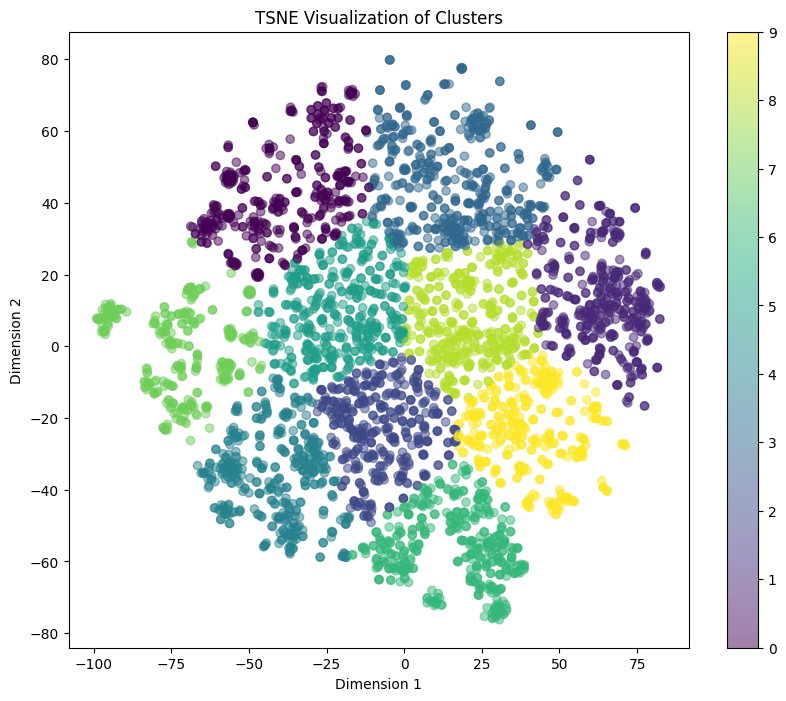

In [306]:

kmeans = KMeans(n_clusters=best_k, random_state=0)
clusters_4 = kmeans.fit_predict(best_embeddings)

unique_descriptions['clusters_4'] = clusters_4

plt.figure(figsize=(10, 8))
scatter = plt.scatter(best_embeddings[:, 0], best_embeddings[:, 1], c=clusters_4, cmap='viridis', alpha=0.5)
plt.colorbar(scatter)
plt.title('TSNE Visualization of Clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [307]:
cluster_distribution = unique_descriptions['clusters_4'].value_counts()
print("Cluster distribution:")
print(cluster_distribution)

Cluster distribution:
clusters_4
3    524
5    461
1    454
6    428
4    424
2    422
0    422
8    411
9    363
7    302
Name: count, dtype: int64


In [308]:
for cluster_num in set(clusters_4):
    if cluster_num != -1:
        cluster_df = unique_descriptions[unique_descriptions['clusters_4'] == cluster_num]['Description'].value_counts()
        
        top_items = cluster_df.head(10)
        print(f"Cluster {cluster_num}:")
        print(top_items.index.tolist())
        print("\n")

Cluster 0:
["POPPY'S PLAYHOUSE BEDROOM", 'CHRISTMAS STAR WISH LIST CHALKBOARD', 'IVORY WIRE KITCHEN ORGANISER', 'ZINC SWEETHEART WIRE LETTER RACK', 'S/2 BEACH HUT TREASURE CHESTS', 'SWEETHEART KEY CABINET', 'mystery! Only ever imported 1800', 'BEACH HUT MIRROR', 'CROCHET WHITE RABBIT KEYRING', 'CROCHET BEAR RED/BLUE  KEYRING']


Cluster 1:
['RED WOOLLY HOTTIE WHITE HEART.', 'CANNABIS LEAF BEAD CURTAIN', 'RESIN BRACELET W PASTEL BEADS', 'TURQUOISE CRYSTAL+GLASS BRACELET', 'GREEN HEART OF GLASS BRACELET', 'TURQUOISE HEART OF GLASS BRACELET', 'METALIC LEAVES BAG CHARMS', 'BLACK 3 BEAD DROP EARRINGS', 'PINK DAISY BAG CHARM', 'RESIN NECKLACE W PASTEL BEADS']


Cluster 2:
['HAND WARMER RED POLKA DOT', 'WRAP DOLLY GIRL', 'SWEETHEART CREAM STEEL TABLE RECT', 'ORANGE TV TRAY TABLE', 'HEN PARTY CORDON BARRIER TAPE', 'BLACK CHRISTMAS FLOCK DROPLET', 'BLUE TILED TRAY', 'JIGSAW TOADSTOOLS 3 PIECE', 'SMALL TALL CAMPHOR WOOD TOADSTOOL', 'DOG BOWL VINTAGE CREAM']


Cluster 3:
['WHITE HANGING HEART T-L

In [309]:
with open('clusters_4_top_20_per_cluster.txt', 'w', encoding='utf-8') as file:
    for cluster_num in set(clusters_4):
        if cluster_num != -1:
            cluster_df = unique_descriptions[unique_descriptions['clusters_4'] == cluster_num]['Description'].value_counts().head(30)
            file.write(f"Cluster {cluster_num}: ")
            file.write('; '.join(cluster_df.index.tolist())) 
            file.write("\n")

Кластер 0: Декор для дома и аксессуары
Примеры:
Спальня POPPY'S PLAYHOUSE
Кухонный органайзер из проволоки цвета слоновой кости
Зеркало в виде пляжного домика
Кластер 1: Ювелирные изделия и модные аксессуары
Примеры:
Красная шерстяная грелка с белым сердцем
Браслет из бирюзового хрусталя и стекла
Ожерелье с белыми розами и жемчугом
Кластер 2: Посуда и кухонные принадлежности
Примеры:
Квадратный стол из кремовой стали "Sweetheart"
Набор из 4 красочных мисок для смешивания
Сковорода в синий горошек
Кластер 3: Декоративные предметы и подарки
Примеры:
Белый подвесной держатель для свечей в виде сердца
Винтажный блокнот "Путешествие"
Большая розовая фоторамка с драгоценностями
Кластер 4: Товары для праздников и торжеств
Примеры:
Винтажная карточная игра "Орёл и решка"
Средняя стеклянная подставка для торта черного цвета
Рождественский чулок с падубом
Кластер 5: Детские игрушки и принадлежности
Примеры:
Набор 7 матрешек
Деревянные кегли для сада
Набор из 4 значков с жуками
Кластер 6: Праздничный декор и свечи
Примеры:
Белый металлический фонарь
Световая цепочка с черными вишнями
Набор из 3 свечей в виде горшков с растениями
Кластер 7: Часы и органайзеры
Примеры:
Будильник розового цвета
Магнитный список покупок с листьями
Настенные часы в стиле ретро
Кластер 8: Сумки и текстиль
Примеры:
Сумка для обеда в красный горошек
Сумка с розовыми клубниками
Кошелек красный с розовым сердцем
Кластер 9: Игрушки и предметы для детей
Примеры:
Кукла-принцесса Charlotte из фетра
Детская садовая вилка синего цвета
Игрушка-робот Mr. Robot

In [310]:
unique_descriptions.to_excel('result.xlsx')

In [311]:
unique_descriptions

,Description,clusters_4
0,WHITE HANGING HEART T-LIGHT HOLDER,3
1,WHITE METAL LANTERN,6
2,CREAM CUPID HEARTS COAT HANGER,3
3,KNITTED UNION FLAG HOT WATER BOTTLE,3
4,RED WOOLLY HOTTIE WHITE HEART.,1
...,...,...
4206,????damages????,7
4207,mixed up,7
4208,lost,7
4209,CREAM HANGING HEART T-LIGHT HOLDER,3
